In [32]:
import sys
import os
sys.path.append(os.path.abspath('../'))
import functions_ml as fml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import shap
import pickle
import math
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from matplotlib.cm import ScalarMappable
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Instâncias de treino

In [33]:
results = pd.read_csv('../datasets/instances_results.csv')
features = pd.read_csv('../datasets/multi_plant_instance_features.csv')
dataset = fml.create_dataset(features, results)
dataset = fml.create_multi_label_target(dataset, 0.1/100)
target_col = [t for t in dataset.columns if t.startswith('RF')]
X = dataset.drop(columns=target_col + ['instance'])
X = fml.binary_feature_selection(X)
y = dataset[target_col]

In [34]:
# Separar subset representativo do treino para poder usar o kernel shap de maneira eficiente
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

# Get train-validation split indices
for other_index, shap_index in msss.split(X, y):
    X_train, X_shap = X.iloc[other_index], X.iloc[shap_index]
    y_train, y_shap = y.iloc[other_index], y.iloc[shap_index]

# Instâncias de teste

In [35]:
test_results = pd.read_csv('../datasets/test_instances_results.csv')
test_features = pd.read_csv('../datasets/test_instances_features.csv')
test_set = fml.create_dataset(test_features, test_results)
test_set = fml.create_multi_label_target(test_set, 0.1/100)

In [36]:
seen_nplants = [2, 4, 6, 15, 20]
seen_nproducts = [10, 60, 120]
unseen_nproducts = [p for p in test_set['num_products'].unique() if p not in seen_nproducts and p > max(seen_nproducts) or p < min(seen_nproducts)] # [np.int64(30), np.int64(150), np.int64(5)]
unseen_nplants = [p for p in test_set['num_plants'].unique() if p not in seen_nplants and p > max(seen_nplants)]  # [np.int64(30), np.int64(10)]
test_set = test_set.loc[~(test_set['num_products'].isin(unseen_nproducts)) &
                        ~(test_set['num_plants'].isin(unseen_nplants))]

In [37]:
X_test = test_set[X_train.columns]
y_test = test_set[[t for t in test_set.columns if t.startswith('RF')]]

# Modelo

In [38]:
with open(f'../trained_models/oracle_0.1percent.pkl', 'rb') as f:
    classifier = pickle.load(f)

# SHAP

In [39]:
# Use X_shap como explainer (subconjunto de 60 instâncias de treino para estimativa dos valores -> Pesadelo computacional) 
explainer = shap.KernelExplainer(model=classifier.predict_proba, data=X_shap, link='logit')

In [40]:
with open('shap_values_all_new_instances.pkl', 'rb') as f:
    shap_values = pickle.load(f)

In [41]:
# Reverse the target_col list to match the SHAP value order in the classifier chain
labels_to_indices = {label: index for index, label in enumerate(target_col)}

# Example output
print(labels_to_indices)

{'RF_1_0': 0, 'RF_2_0': 1, 'RF_2_1': 2, 'RF_3_0': 3, 'RF_3_1': 4, 'RF_3_2': 5, 'RF_4_0': 6, 'RF_4_1': 7, 'RF_4_2': 8, 'RF_4_3': 9, 'RF_6_0': 10, 'RF_6_1': 11, 'RF_6_2': 12, 'RF_6_3': 13, 'RF_6_4': 14, 'RF_6_5': 15, 'RF_T_0': 16}


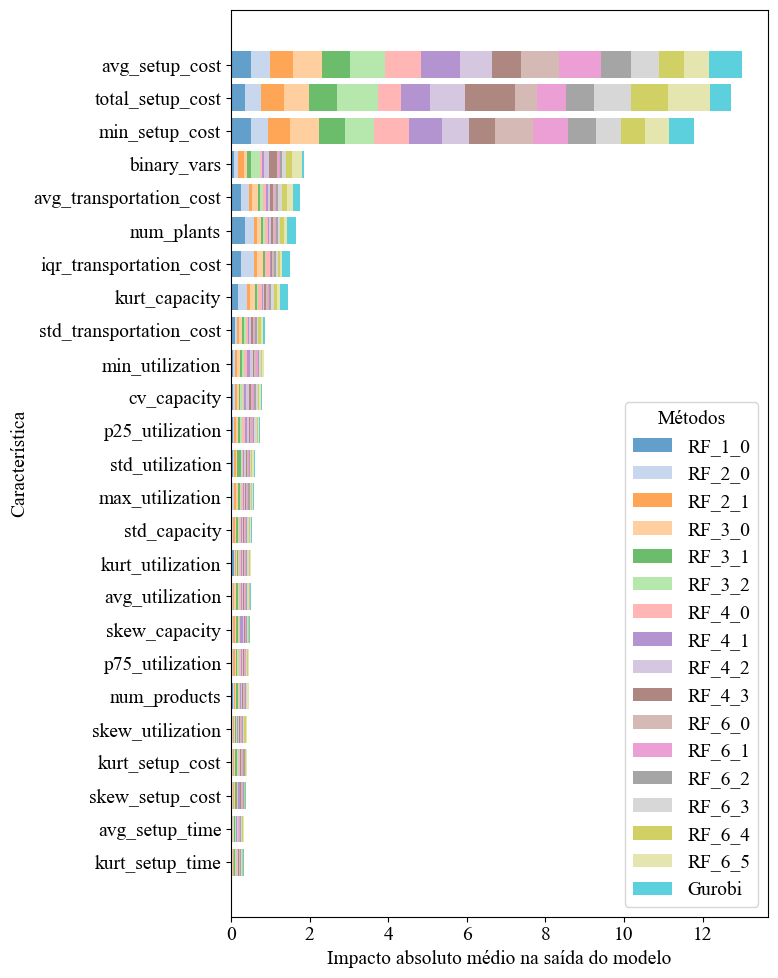

In [42]:
# Ensure feature_names and label_names are properly defined
feature_names = X_test.columns  # Replace with your feature names
label_names = list(labels_to_indices.keys())  # Replace with your label names
label_names[-1] = 'Gurobi'  # Modify the first label if necessary

# Aggregate SHAP values (mean absolute values over all instances)
shap_values_mean = np.mean(np.abs(shap_values), axis=0)  # Shape: (25, 17)

# Sort features by the total SHAP value across all labels (descending)
total_shap_values = np.sum(shap_values_mean, axis=1)
sorted_indices = np.argsort(total_shap_values)[::-1]
shap_values_mean_sorted = shap_values_mean[sorted_indices]
feature_names_sorted = [feature_names[i] for i in sorted_indices]

# Reverse y_pos to have the biggest bar at the top
y_pos = np.arange(len(feature_names_sorted))[::-1]  # Reverse the order for top features

# Create a colormap with at least 17 distinct colors
cmap = get_cmap("tab20")  # Use tab20 or another suitable colormap
colors = [cmap(i / len(label_names)) for i in range(len(label_names))]

# Initialize cumulative values for stacking
cumulative_values = np.zeros(len(feature_names_sorted))

# Create the plot
fig, ax = plt.subplots(figsize=(8, 10))  # Adjust figure size

for i, label in enumerate(label_names):
    ax.barh(
        y_pos,
        shap_values_mean_sorted[:, i],  # SHAP values for label `i`
        left=cumulative_values,  # Start stacking from cumulative values
        color=colors[i],
        label=label,
        alpha=0.7  # Slightly increase transparency
    )
    cumulative_values += shap_values_mean_sorted[:, i]  # Update cumulative values

# Add feature names to the y-axis
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_names_sorted, fontsize=12)  # Adjust font size for readability
ax.set_xlabel("Impacto absoluto médio na saída do modelo", fontsize=14)
ax.set_ylabel("Característica", fontsize=14)  # Y-axis label customization

# Position the legend in the lower-right corner inside the figure
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    # handles[::-1],  # Reverse the handles
    # labels[::-1],  # Reverse the labels
    title='Métodos', 
    loc='lower right', 
    fontsize=14, 
    frameon=True, 
    fancybox=True
)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig('fig_shap_oracle_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [43]:
def plot_summary_plot_label(label_name, shap_values, X_test_shap, label_names, save_path=None):
    # Find the index of the target label
    try:
        target_label_index = label_names.index(label_name)
    except ValueError:
        raise ValueError(f"Label '{label_name}' not found in label_names.")
    print(f'Target label index: {target_label_index}')
    # Extract SHAP values for the selected label
    shap_values_label = shap_values[:, :, target_label_index]

    # Create a custom figure and axis for consistent figsize
    fig, ax = plt.subplots(figsize=(2, 1))  # Adjust figure size as needed

    # Generate the SHAP summary plot
    shap.summary_plot(
        shap_values_label,  # SHAP values for the selected label
        X_test_shap,
        max_display=10,
        show=False,
        plot_type="dot",  # Keep the "dot" style
    )

    # Access the color bar
    cbar = plt.gcf().axes[-1]

    # Customize color bar ticks and labels
    cbar.set_yticks([0, 1])  # Set the tick positions
    cbar.set_yticklabels(['Baixo', 'Alto'], fontsize=14)  # Custom labels
    cbar.set_ylabel("Valor da característica", fontsize=16)  # Add color bar label

    # Customize additional plot properties
    ax.set_xlabel("Impacto na saída do modelo", fontsize=16)
    ax.set_ylabel("Característica", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Save the plot if a path is provided
    if save_path:
        filename = f"{save_path}/shap_summary_{label_name}.png"
        plt.tight_layout()
        plt.savefig(filename, dpi=300, bbox_inches="tight")
        print(f"Plot saved to {filename}")

    # Display the plot
    plt.show()

In [47]:
def shap_summary_plot_grid(labels, shap_values, X_test_shap, label_names, max_features=10, save_path=None, subplot_width=6, subplot_height=4):
    """
    Plots a grid of SHAP summary plots, one for each label.

    Parameters:
    - labels: List of label names to plot.
    - shap_values: SHAP values with shape (instances, features, labels).
    - X_test_shap: Feature data used for SHAP explanations.
    - label_names: Full list of label names.
    - max_features: Maximum number of features to display per label plot.
    - save_path: Path to save the grid plot if provided.
    - subplot_width: Width of each subplot.
    - subplot_height: Height of each subplot.
    """
    print(f"Shape of shap_values: {shap_values.shape}")
    print(f"Number of label names: {len(label_names)}")
    print(f"Labels to plot: {labels}")

    # Define the grid size
    n_labels = len(labels)
    ncols = 3  # Fixed to 3 columns
    nrows = math.ceil(n_labels / ncols)

    # Create a larger figure to accommodate SHAP plots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(subplot_width * ncols, subplot_height * nrows))
    axes = axes.ravel()  # Flatten the axes array for easy indexing

    global_min = np.min(shap_values)
    global_max = np.max(shap_values)


    # Loop through each label and plot
    for i, label_name in enumerate(labels):
        try:
            # Find the index for the current label
            target_label_index = label_names.index(label_name)

            # Extract SHAP values for the current label
            shap_values_label = shap_values[:, :, target_label_index]

            # Set the current subplot as active
            plt.sca(axes[i])  # Set the current axis for plotting

            # Generate a SHAP summary plot for the current label
            shap.summary_plot(
                shap_values_label,
                X_test_shap,
                max_display=max_features,
                show=False  # Prevent SHAP from auto-displaying the plot
            )

            axes[i].tick_params(axis='x', labelsize=18)
            axes[i].set_xlim(global_min, global_max)

            # Enforce size adjustments for the current plot
            fig = plt.gcf()
            fig.set_size_inches(subplot_width * ncols, subplot_height * nrows)

            for text in axes[i].get_yticklabels():
                text.set_fontsize(18)

            # Access the color bar
            cbar = plt.gcf().axes[-1]

            # Customize color bar ticks and labels
            cbar.set_yticks([0, 1])  # Set the tick positions
            cbar.set_yticklabels(['Baixo', 'Alto'], fontsize=18)  # Custom labels
            if i in [2, 5, 8, 11, 14, 16]:
                cbar.set_ylabel("Valor da característica", fontsize=20)
            else:
                cbar.set_ylabel("", fontsize=1)

            if i not in [2, 5, 8, 11, 14, 16]:
                cbar.remove()

            # Add title to the subplot
            axes[i].set_title(label_name, fontsize=22)
            if i in [14, 15, 16]:
                axes[i].set_xlabel("Impacto na saída do modelo", fontsize=20)
            else:
                axes[i].set_xlabel("", fontsize=1)

        except ValueError as e:
            print(f"Error plotting for label {label_name}: {e}")
            axes[i].axis('off')  # Disable unused subplot

    # Hide unused subplots if the number of labels is less than grid size
    for j in range(len(labels), len(axes)):
        axes[j].axis('off')

    # Adjust layout for better spacing
    fig.tight_layout()

    # Save the figure if a path is provided
    if save_path:
        filename = f"{save_path}/shap_summary_grid.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight")
        print(f"Grid plot saved to {filename}")

    # Display the grid of plots
    plt.show()


Shape of shap_values: (64, 25, 17)
Number of label names: 17
Labels to plot: ['RF_1_0', 'RF_2_0', 'RF_2_1', 'RF_3_0', 'RF_3_1', 'RF_3_2', 'RF_4_0', 'RF_4_1', 'RF_4_2', 'RF_4_3', 'RF_6_0', 'RF_6_1', 'RF_6_2', 'RF_6_3', 'RF_6_4', 'RF_6_5', 'Gurobi']
Grid plot saved to ./shap_summary_grid.png


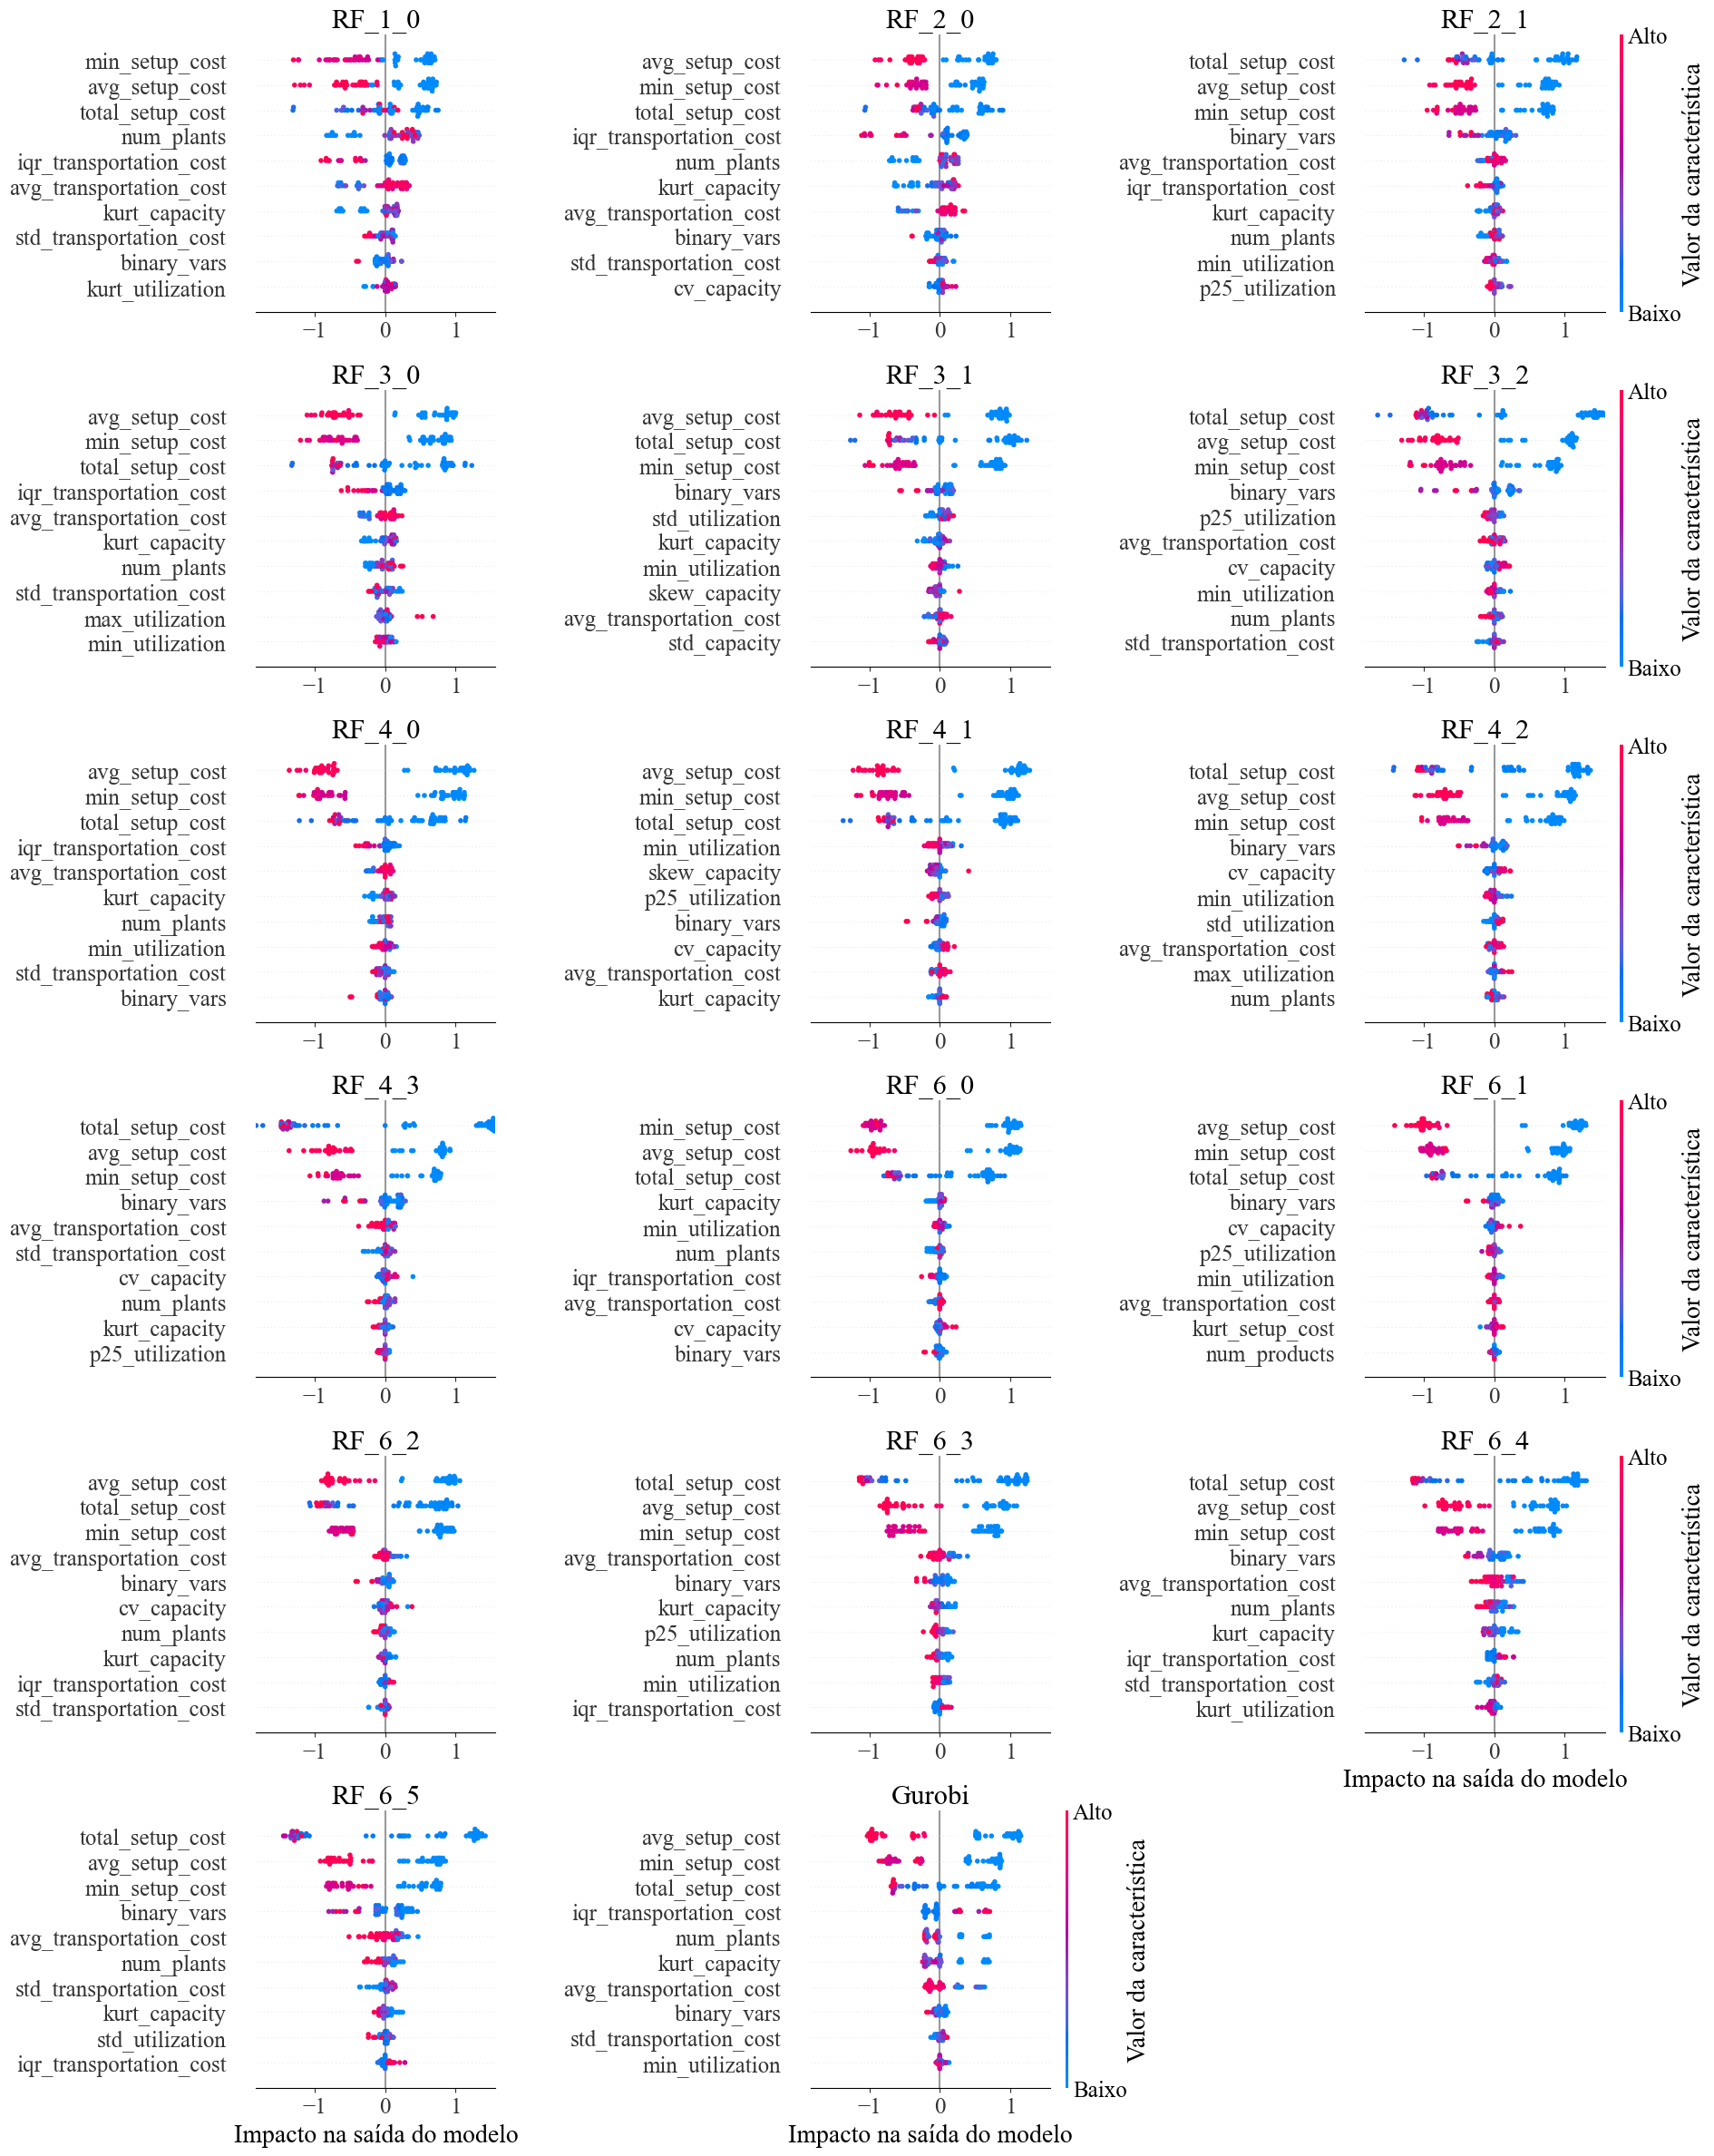

In [48]:
shap_summary_plot_grid(
    labels=label_names,  # First 16 labels
    shap_values=shap_values,  # SHAP values (instances, features, labels)
    X_test_shap=X_test,  # Feature data
    label_names=label_names,  # Full list of label names
    max_features=10,          # Top 10 features
    subplot_width=6.5,         # Adjust width for better readability
    subplot_height=4,          # Adjust height for better readability
    save_path='.'
)


Target label index: 15


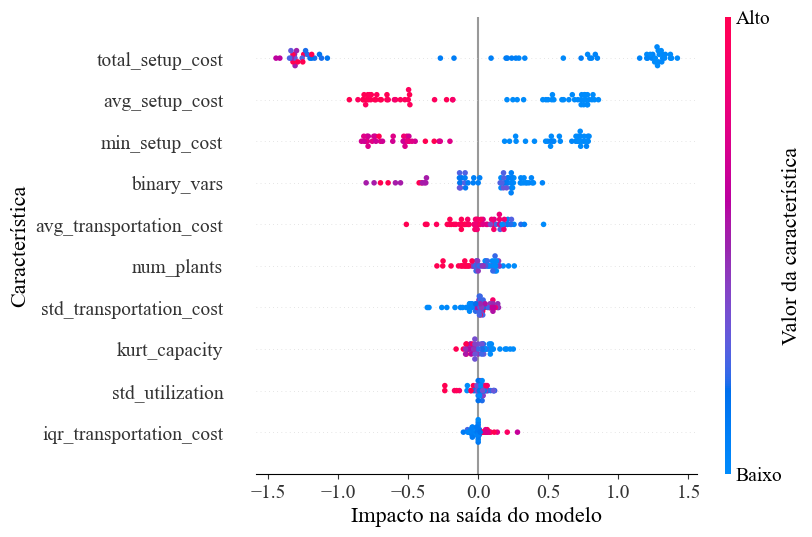

In [46]:
plot_summary_plot_label(
    label_name="RF_6_5", 
    shap_values=shap_values, 
    X_test_shap=X_test, 
    label_names=label_names
)